# Riemannian Score Table

This notebook estimates the diffusion t-mean for synthetic data compared to the estimation using bridge sampling. Further time-complexity is estimated in this note book

In [1]:
from jaxgeometry.manifolds import *
from jaxgeometry.integration import dts
from jaxgeometry.autodiff import jacfwdx
from jaxgeometry.statistics import Frechet_mean
from jaxgeometry.statistics.score_matching import diffusion_mean
import jaxgeometry.statistics as jstat
import jaxgeometry.stochastics as jstoch
import jax.numpy as jnp
import haiku as hk
import jax
from jax import vmap

import pandas as pd

import os

import pickle

from tabulate import tabulate

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from jaxgeometry.statistics.score_matching import model_loader
from models import models

2024-05-21 09:51:49.582122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
plt.rcParams.update({'font.size': 20})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

# Load Estimation Error and Time

In [3]:
manifold = 'Sphere'

In [4]:
path = f"../results/estimates/timing_{manifold}.pkl"
figure_path = "../figures/timing/"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [5]:
with open(path, 'rb') as f:
    estimates = pickle.load(f)

## Score Table

### Plotting Estimates

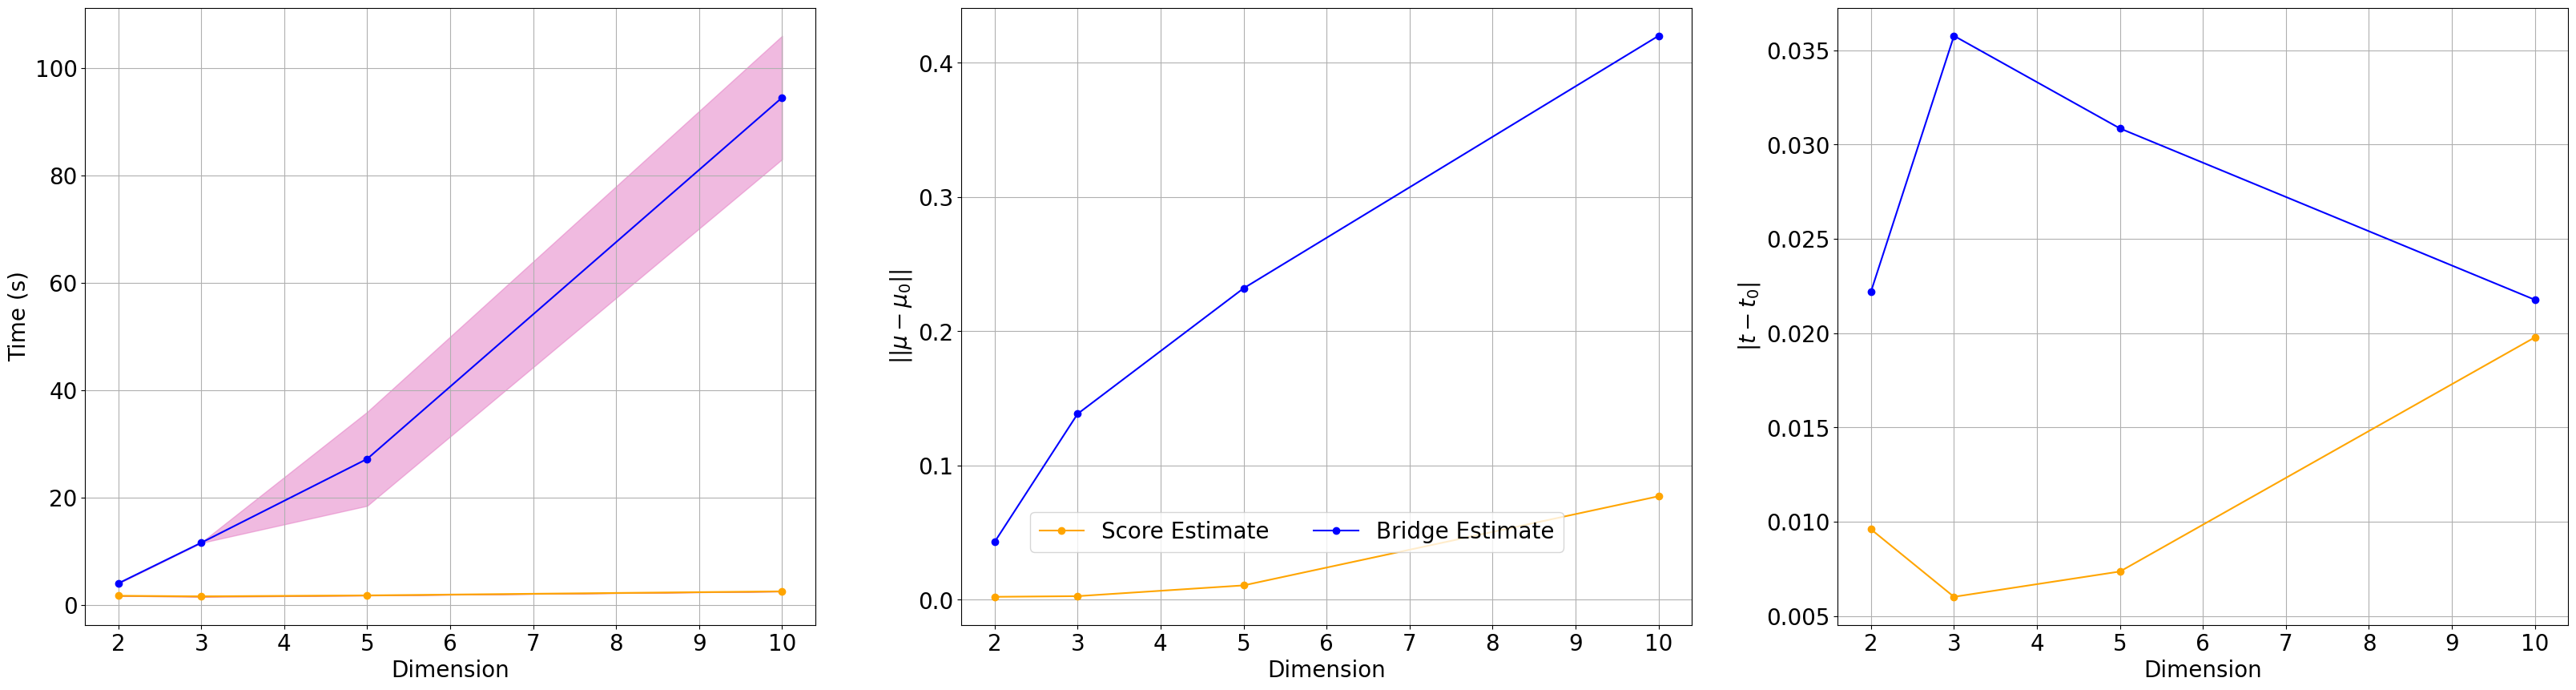

In [6]:
#Plotting time difference
fig = plt.figure(figsize=(40,10))
ax = fig.add_subplot(131)
ax.plot(estimates['dim'], 
        estimates['score_mu_time'], '-o',color='orange', label='Score Estimate')
ax.plot(estimates['dim'], 
        estimates['bridge_mu_time'], '-o',color='blue', label='Bridge Estimate')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Time (s)')
ax.fill_between(
    estimates['dim'],
    jnp.maximum(estimates['score_mu_time'] - 1.96 * estimates['score_std_time'], 
                jnp.zeros_like(estimates['score_mu_time'])),
    jnp.maximum(estimates['score_mu_time'] + 1.96 * estimates['score_std_time'], 
                jnp.zeros_like(estimates['score_mu_time'])),
    color="tab:red",
    alpha=0.5,
)
ax.fill_between(
    estimates['dim'],
    jnp.maximum(estimates['bridge_mu_time'] - 1.96 * estimates['bridge_std_time'], 
                jnp.zeros_like(estimates['bridge_mu_time'])),
    jnp.maximum(estimates['bridge_mu_time'] + 1.96 * estimates['bridge_std_time'], 
                jnp.zeros_like(estimates['bridge_mu_time'])),
    color="tab:pink",
    alpha=0.5,
)
ax.grid(True)

ax = fig.add_subplot(132)
ax.plot(estimates['dim'], 
        estimates['score_mu_error'], '-o',color='orange')
ax.plot(estimates['dim'], 
        estimates['bridge_mu_error'], '-o',color='blue')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(r'$||\mu-\mu_{0}||$')
ax.grid(True)

ax = fig.add_subplot(133)
ax.plot(estimates['dim'], 
        estimates['score_t_error'], '-o',color='orange')
ax.plot(estimates['dim'], 
        estimates['bridge_t_error'], '-o',color='blue')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(r'$|t-t_{0}|$')
ax.grid(True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.40,0.2), ncol=5)

plt.show()

save_path = f'{figure_path}{manifold}.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')


### Table Estimates

In [24]:
names = [r"muscore", r"mubridge", 
        r"tscore", r"tbridge",
        r"dim", r"s1n", r"s2n", r'score_time', r'bridge_time']

table_dict = estimates.copy()
val = [f"{table_dict['score_mu_time'][i]:.4f} +/- {table_dict['score_std_time'][i]:.4f}" for i in range(len(table_dict['score_mu_time']))]
table_dict['score_time'] = val
val = [f"{table_dict['bridge_mu_time'][i]:.4f} +/- {table_dict['bridge_std_time'][i]:.4f}" for i in range(len(table_dict['score_mu_time']))]
table_dict['bridge_time'] = val
table_dict['s1_ntrain'] *= 100
table_dict['dt_ntrain'] *= 100
del table_dict['score_mu_time']
del table_dict['score_std_time']
del table_dict['bridge_mu_time']
del table_dict['bridge_std_time']

print(tabulate(table_dict, headers=names, floatfmt=".4f"))


  muscore    mubridge    tscore    tbridge    dim         s1n    s2n  score_time         bridge_time
---------  ----------  --------  ---------  -----  ----------  -----  -----------------  -------------
   0.1272         nan    0.0258        nan      2  49200.0000    nan  0.7114 +/- 0.0189  nan +/- nan
   0.1491         nan    0.0206        nan      3  47800.0000    nan  0.6844 +/- 0.0209  nan +/- nan
   0.2663         nan    0.0556        nan      5  45100.0000    nan  0.7268 +/- 0.0192  nan +/- nan


## Frechet Table

In [25]:
manifold = 'SPDN'

In [26]:
path = f"../results/estimates/timing_frechet_{manifold}.pkl"
figure_path = "../figures/timing/"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [27]:
with open(path, 'rb') as f:
    estimates = pickle.load(f)

### Plotting Estimates

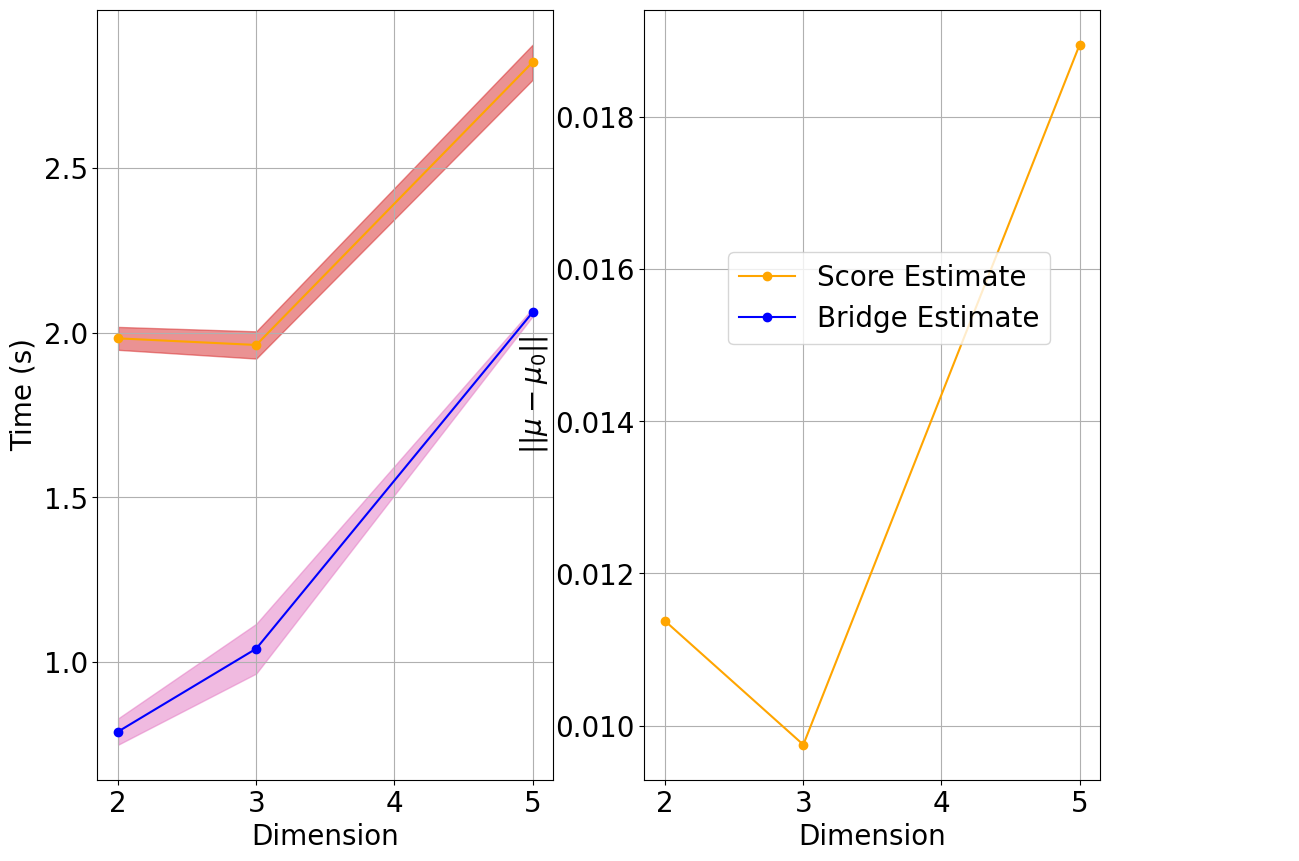

In [28]:
#Plotting time difference
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(131)
ax.plot(estimates['dim'], 
        estimates['score_mu_time'], '-o',color='orange', label='Score Estimate')
ax.plot(estimates['dim'], 
        estimates['frechet_mu_time'], '-o',color='blue', label='Bridge Estimate')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Time (s)')
ax.fill_between(
    estimates['dim'],
    jnp.maximum(estimates['score_mu_time'] - 1.96 * estimates['score_std_time'], 
                jnp.zeros_like(estimates['score_mu_time'])),
    jnp.maximum(estimates['score_mu_time'] + 1.96 * estimates['score_std_time'], 
                jnp.zeros_like(estimates['score_mu_time'])),
    color="tab:red",
    alpha=0.5,
)
ax.fill_between(
    estimates['dim'],
    jnp.maximum(estimates['frechet_mu_time'] - 1.96 * estimates['frechet_std_time'], 
                jnp.zeros_like(estimates['frechet_mu_time'])),
    jnp.maximum(estimates['frechet_mu_time'] + 1.96 * estimates['frechet_std_time'], 
                jnp.zeros_like(estimates['frechet_mu_time'])),
    color="tab:pink",
    alpha=0.5,
)
ax.grid(True)

ax = fig.add_subplot(132)
ax.plot(estimates['dim'], 
        estimates['score_mu_error'], '-o',color='orange')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(r'$||\mu-\mu_{0}||$')
ax.grid(True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.56,0.6), ncol=1)

plt.show()

save_path = f'{figure_path}frechet_{manifold}.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')


### Table Estimates

In [29]:
names = [r"muscore", r"dim", r"s1n", r'score_time', r'frechet_time']

table_dict = estimates.copy()
val = [f"{table_dict['score_mu_time'][i]:.4f} +/- {table_dict['score_std_time'][i]:.4f}" for i in range(len(table_dict['score_mu_time']))]
table_dict['score_time'] = val
val = [f"{table_dict['frechet_mu_time'][i]:.4f} +/- {table_dict['frechet_mu_time'][i]:.4f}" for i in range(len(table_dict['frechet_mu_time']))]
table_dict['frechet_time'] = val
table_dict['s1_ntrain'] *= 10
del table_dict['score_mu_time']
del table_dict['score_std_time']
del table_dict['frechet_mu_time']
del table_dict['frechet_std_time']

print(tabulate(table_dict, headers=names, floatfmt=".4f"))

  muscore    dim         s1n  score_time         frechet_time
---------  -----  ----------  -----------------  -----------------
   0.0114      2   5010.0000  1.9825 +/- 0.0177  0.7893 +/- 0.7893
   0.0097      3  22640.0000  1.9625 +/- 0.0211  1.0409 +/- 1.0409
   0.0190      5   5010.0000  2.8204 +/- 0.0272  2.0614 +/- 2.0614
